In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
path = os.path.join(os.getcwd(), "datasets", "animals10", "raw-img")
class_list = os.listdir(path)
class_list.remove('.DS_Store')
data_paths = [os.listdir(os.path.join(path, c)) for c in class_list]
sample_n = [len(c) for c in data_paths]
print(class_list)

['cat', 'butterfly', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']


In [3]:
import numpy as np
class Dataset:
    def __init__(self, BS, shuffle=True):
        self.BS = BS
        self.XIndex = list()
        self.y = list()
        for i, yi in enumerate(sample_n):
            for xi in range(yi):
                self.y.append(i)
                self.XIndex.append(xi)
        self.XIndex = np.array(self.XIndex)
        self.y = np.array(self.y)
        self.l = len(self.y)
        if shuffle:
            randl = list(range(self.l))
            np.random.shuffle(randl)
            self.XIndex = self.XIndex[randl]
            self.y = self.y[randl]
    def __len__(self):
        return int(np.ceil(self.l/self.BS))
    def __getitem__(self, key):
        start = key * self.BS
        assert start < self.l
        stop = start + self.BS
        if stop > self.l and start < self.l:
            stop = self.l
        return self.XIndex[start:stop], self.y[start:stop]
    def __iter__(self):
        for b in range(len(self)):
            start = b*self.BS
            X, y = self.XIndex[start:start+self.BS], self.y[start:start+self.BS]
            X_path = list()
            for xs, ys in zip(X, y):
                X_path.append(os.path.join(path,class_list[ys],data_paths[ys][xs]))
            X_path = np.array(X_path)
            X_Images = self.toMem(X_path)
            yield X_Images, y
    def toMem(self, X_path):
        from PIL import Image
        X_images = list()
        for img_path in X_path:
            im = Image.open(img_path)
            X_images.append(im)
        return X_images
        
'''
getdata = Dataset(BS=150)
for x_b, y_b in getdata:
    print(type(x_b[0]))
    # print(x_b, y_b, x_b.shape, y_b.shape)
'''

'\ngetdata = Dataset(BS=150)\nfor x_b, y_b in getdata:\n    print(type(x_b[0]))\n    # print(x_b, y_b, x_b.shape, y_b.shape)\n'

In [20]:
import torch
# torch.manual_seed(17)
from torchvision import datasets, transforms
BS = 8
IM_HEIGHT = 425
IM_WIDTH = 600
transform = transforms.Compose([transforms.Resize([IM_HEIGHT, IM_WIDTH]), transforms.ToTensor()])
path = os.path.join(os.getcwd(), "datasets", "animals10", "raw-img")
dataset = datasets.ImageFolder(path, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)*0.3)+1])
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True)
val_set_loader = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=True)

AttributeError: 'Subset' object has no attribute 'reshape'

torch.Size([8, 3, 425, 600]) torch.Size([3, 425, 600])
tensor([[0.1373, 0.1373, 0.1333,  ..., 0.1765, 0.1725, 0.1686],
        [0.1373, 0.1373, 0.1333,  ..., 0.1765, 0.1725, 0.1686],
        [0.1373, 0.1373, 0.1333,  ..., 0.1843, 0.1804, 0.1765],
        ...,
        [0.0706, 0.0745, 0.0745,  ..., 0.1059, 0.0784, 0.0667],
        [0.0549, 0.0588, 0.0627,  ..., 0.0784, 0.0588, 0.0431],
        [0.0549, 0.0588, 0.0627,  ..., 0.0745, 0.0549, 0.0431]])


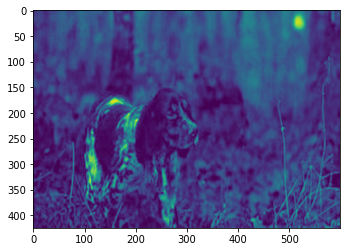

tensor([[0.3098, 0.3098, 0.3098,  ..., 0.5569, 0.5451, 0.5373],
        [0.3098, 0.3098, 0.3098,  ..., 0.5569, 0.5451, 0.5373],
        [0.3098, 0.3098, 0.3098,  ..., 0.5608, 0.5490, 0.5451],
        ...,
        [0.2392, 0.2431, 0.2471,  ..., 0.4941, 0.4627, 0.4431],
        [0.2275, 0.2314, 0.2353,  ..., 0.4627, 0.4353, 0.4196],
        [0.2275, 0.2314, 0.2353,  ..., 0.4588, 0.4314, 0.4157]])
tensor(0.)
tensor(0.9961)


In [14]:
import matplotlib.pyplot as plt
i, l = next(iter(train_set_loader))
print(i.shape, i[0].shape)
sample = i[0][2]
print(sample)
plt.imshow(i[0][2].reshape(IM_HEIGHT, IM_WIDTH))
plt.show()
print(i[0][0])
print(torch.min(i[0][0]))
print(torch.max(i[0][0]))

In [15]:
import torch.nn as nn
import torch.nn.functional as F
class someNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(IM_HEIGHT*IM_WIDTH*3, 10)
        nn.init.normal_(self.l1.weight, mean=0, std=0.1)
    def forward(self, x):
        x = self.l1(x)
        x = F.log_softmax(x)
        return x

model = someNet()

In [16]:
WAN = False
N_EPOCH = 10
LR = 0.01

In [9]:
if WAN:
  import wandb
  wandb.init(project="animals10", entity="0xasim")
  wandb.config = {
    "learning_rate": LR,
    "epochs": N_EPOCH,
    "batch_size": BS
  }

In [50]:
from tqdm import tqdm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
review = lambda x_b: x_b.view(len(x_b), -1)
def train():
    for i in (range(N_EPOCH)):
        batch_loss = list()
        for x_b, y_b in tqdm(train_set_loader):
            x_b = review(x_b)
            pred = model.forward(x_b)
            loss = loss_fn(pred, y_b)
            # clear gradients for this training step
            optimizer.zero_grad()
            # backprop, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            batch_loss.append(loss.sum()/y_b.shape[0])
            if WAN:
                wandb.log({"train_loss": loss.sum().item()})
        if WAN:
            wandb.log({"val_loss": getValLoss()})
train()



/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_59329/2340960354.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)

































































































































KeyboardInterrupt: 

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.4/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Cellar/python@3.10/3.10.4/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 152, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/opt/homebrew/lib/python3.10/site-packages/wandb/sdk/interface/interface.py", line 138, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/opt/homebrew/lib/python3.10/site-packages/wandb/sdk/interface/interface_shared.py", line 405, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/opt/homebrew/lib/python3.10/site-package

In [ ]:
def getValLoss():
    with torch.no_grad():
        val_loss = list()
        for x_v_b, y_v_b in tqdm(val_set_loader):
            x_v_b = torch.tensor([torch.flatten(e_x).numpy() for e_x in x_v_b])
            pred = model.forward(x_v_b)
            loss = loss_fn(pred, y_v_b)
            val_loss.append(loss.sum()/y_v_b.shape[0])
            print(val_loss)
        return val_loss.sum().item()
getValLoss()